In [3]:
# I'm going rogue and starting with one of the flights I'm interested in....
# Based on Will's tutorial notebook

## Here is a list of objectives for this tutorial. Try to find (cmd-f) these numbers in the commented sections:
    # 1)  - Import our class functions and verify installation
    # 2)  - Load Drone Data
    # 3)  - Load Correlator Data
    # 4)  - Initialize a concat class for a PULSED GRID FLIGHT
    # 5)  - Perform a series of analysis functions on the concat class...
    # 5A) - concat Function: Extract_Source_Pulses
    # 5B) - concat Function: Perform_Background_Subtraction
    # 5C) - concat Function: Synchronization_Function
    # 5D) - concat Function: Export_yaml
    # 5E) - concat Function: Main_Beam_Fitting

In [4]:
## First import general packages for running python analysis:
import os
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import h5py
import datetime
import pytz
import pickle

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

In [5]:
# Useful analysis stuff I will need to somehow code:
#Epols = [0,3,4,7,9,10,12,14]
#Npols = [1,2,5,6,8,11,13,15]

Epols = [0,2,4,6,8,10,12,14]
Npols = [1,3,5,7,9,11,13,15]

# dishes are 2n, 2n+1 pairs

In [6]:
###################
#### FUNCTIONS ####
###################

## 1. Fitting time offsets, background, writing yamls and Gaussian values

20210826T182915Z /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/ /hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T182904Z_yale_drone_yale_digitalgain/
Initializing drone data via datcon_csv routine: FLY533.csv
  --> Skipping rows 1 to 2299 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 9200/9200 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [1900:11000]


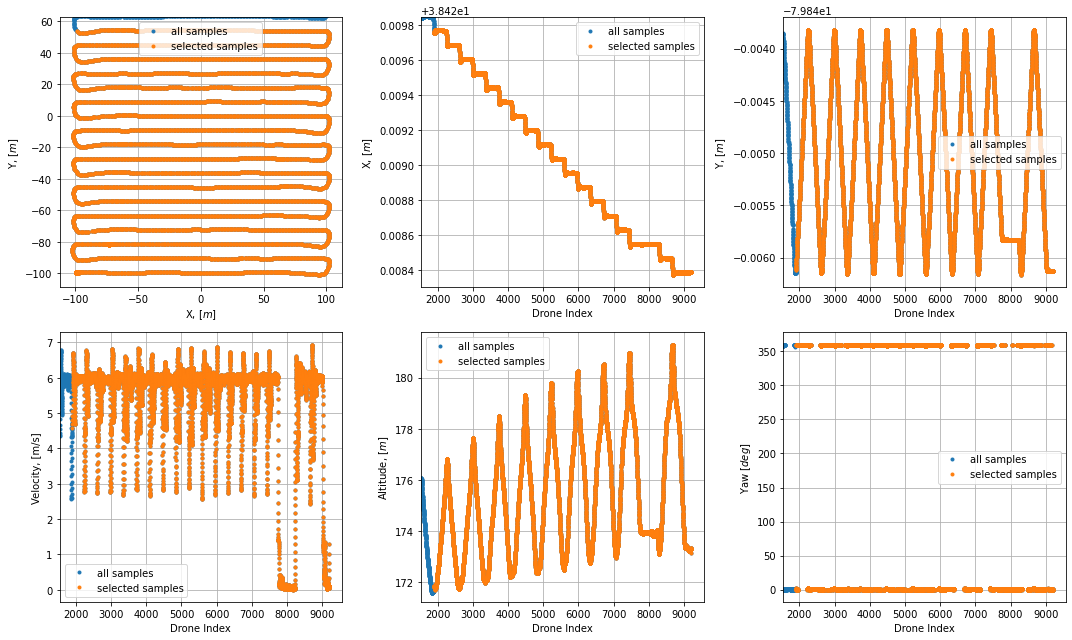

In [46]:
# Checking if the flight and numbers correspond from what I've written in the spreadsheet

[tlb,tub]=[0,-1] # default values to read in full array

fly = '533'
cdat= '20210826T182904Z'
[tlb,tub]=[1800,11000]

#fly = '534'
#cdat = '20210826T185621Z'
#[tlb,tub]=[1900,11000]

#fly = '535'
#cdat = '20210826T192056Z'

#fly = '536'
#cdat = '20210826T195003Z'

#fly='613'
#cdat='20211021T144905Z'

#fly = '615'
#cdat = '20211021T151650Z'

#fly = '618'
#cdat = '20211021T183430Z'


if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    aindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

pu.Plot_Drone_Coordinates(dronetest0825,coo='xy',t_bounds=[1900,11000])


start time:  2023-03-11 14:19:27.502962
Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> Arrays initialized with shape (124, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0123/0123
  --> Finished. Reshaping arrays.
end time:  2023-03-11 14:29:59.047168


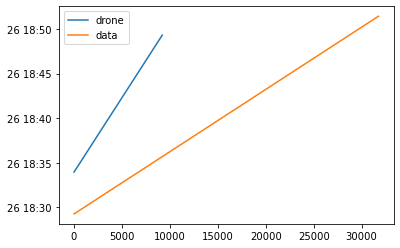

In [50]:
## Combine drone and correlator data
print('start time: ', datetime.datetime.now())
corrtest0825=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite,crossmap=[])
print('end time: ', datetime.datetime.now())

# putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
# This checks I copied and pasted ok :)

## plot their datetime arrays to check overlap:

plot(dronetest0825.t_arr_datetime,label='drone')
plot(corrtest0825.t_arr_datetime,label='data')
legend()


Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> FLY533.csv
Creating directory for saving traceback and analysis outputs:
  --> /hirax/GBO_Analysis_Outputs/FLY533_20210826T182904Z_ver_20230311T143009/
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 21994 elements
  --> drone timestamp axis contains 9200 elements


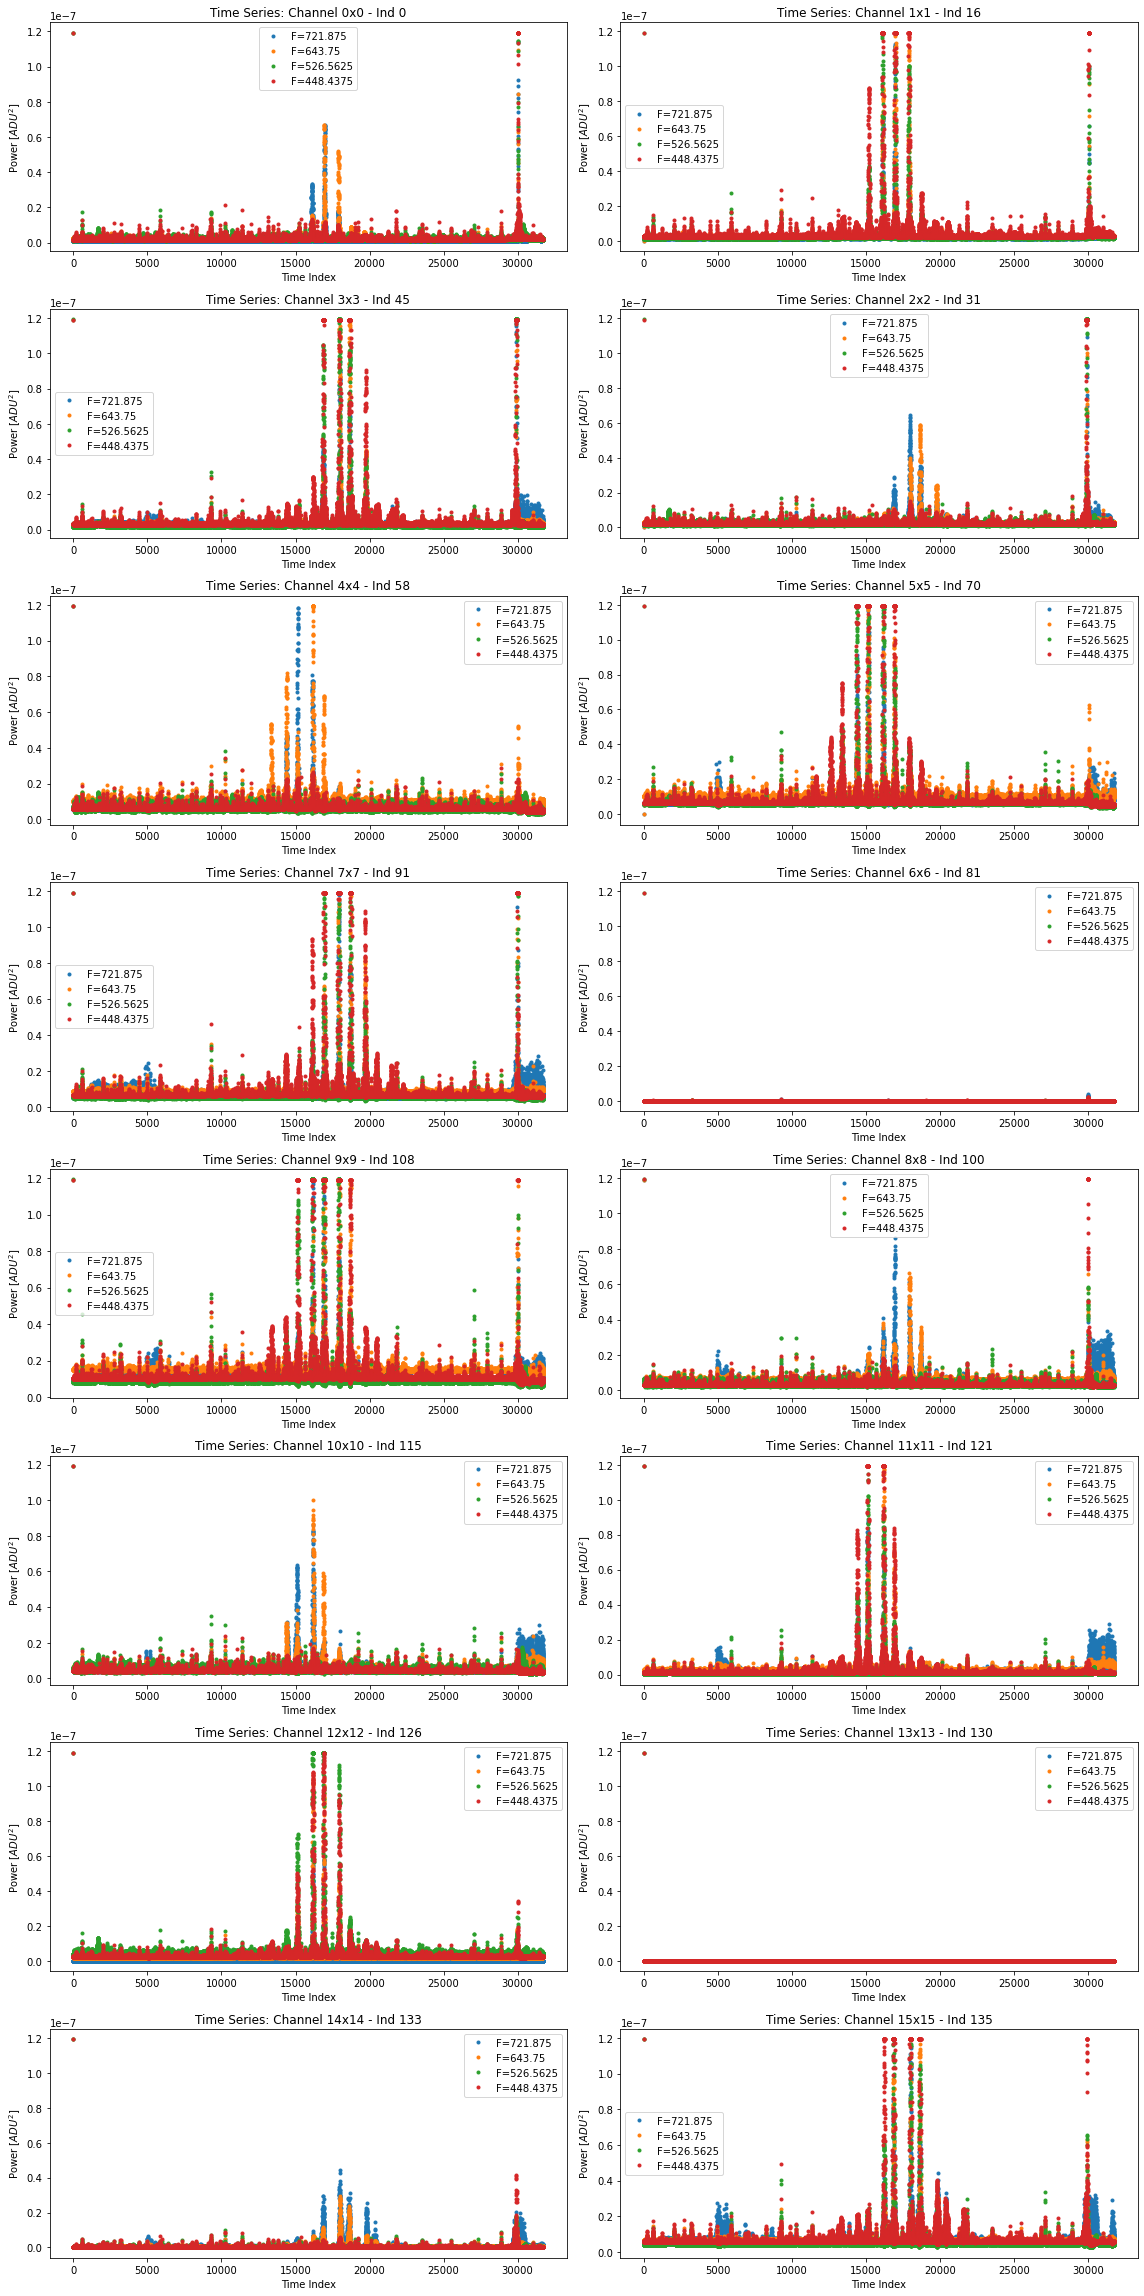

In [51]:
# Match drone and correlator data together, and plot a few frequencies

config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=True,save_traceback=True)
#concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,load_yaml=True,traceback=True,save_traceback=False)

pu.Plot_Time_Series(concattest0825,freqlist=[200,400,700,900]) # previously set to just 700

(13000.0, 22000.0)

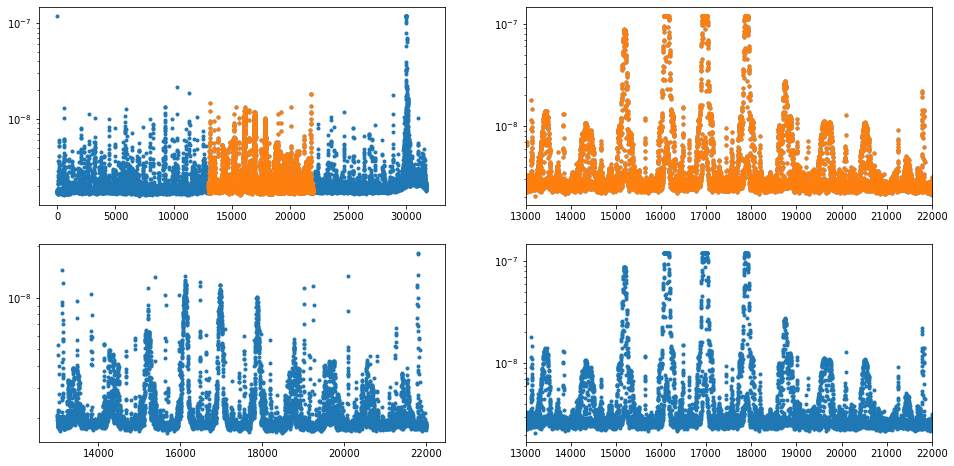

In [52]:
## Let's find the time bounds for a central transit, and examine those bounds when we solve for the source pulses:
tlb,tub=[13000,22000]
find=900

fig=figure(figsize=(16,8))
for i in range(concattest0825.n_channels)[:2]:
    ax1=fig.add_subplot(2,2,i+1)
    ax2=fig.add_subplot(2,2,i+3)
    ax1.semilogy(concattest0825.t_index[:],concattest0825.V[:,find,concattest0825.chmap[i]],'.')
    for ax in [ax1,ax2]:
        ax.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[tlb:tub,find,concattest0825.chmap[i]],'.')
ax1.set_xlim(tlb,tub)
ax2.set_xlim(tlb,tub)

## So we've identified time bounds where we can see the pulsing source transit!
    ## Infact, I think we are seeing a sidelobe on channel 1!
    ## Let's see if we can extract the on/off indices...

Maximum Pearson_R Correlations between data and square wave function:
  --> t_indices = [399. 413. 403. 411. 413. 413. 518. 415. 414. 420. 413. 413. 409. 689.
 397. 415.]
  --> t_deltas = [-0.24  -0.235 -0.239 -0.235 -0.235 -0.235 -0.193 -0.234 -0.234 -0.232
 -0.235 -0.235 -0.236 -0.124 -0.241 -0.234]
Selecting square wave function time offset:
  --> t_delta_pulse = -0.2346346346
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


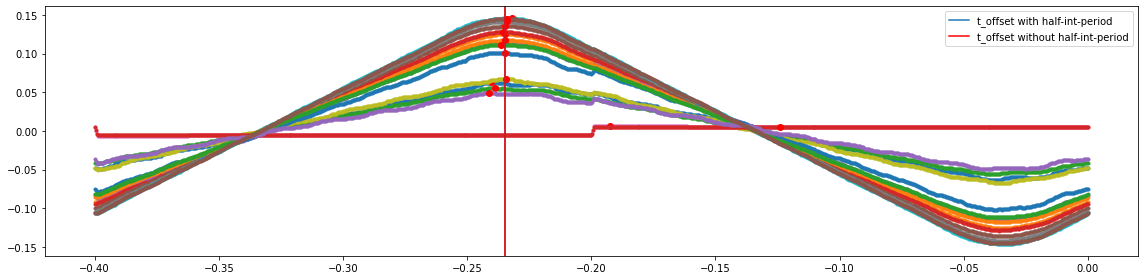

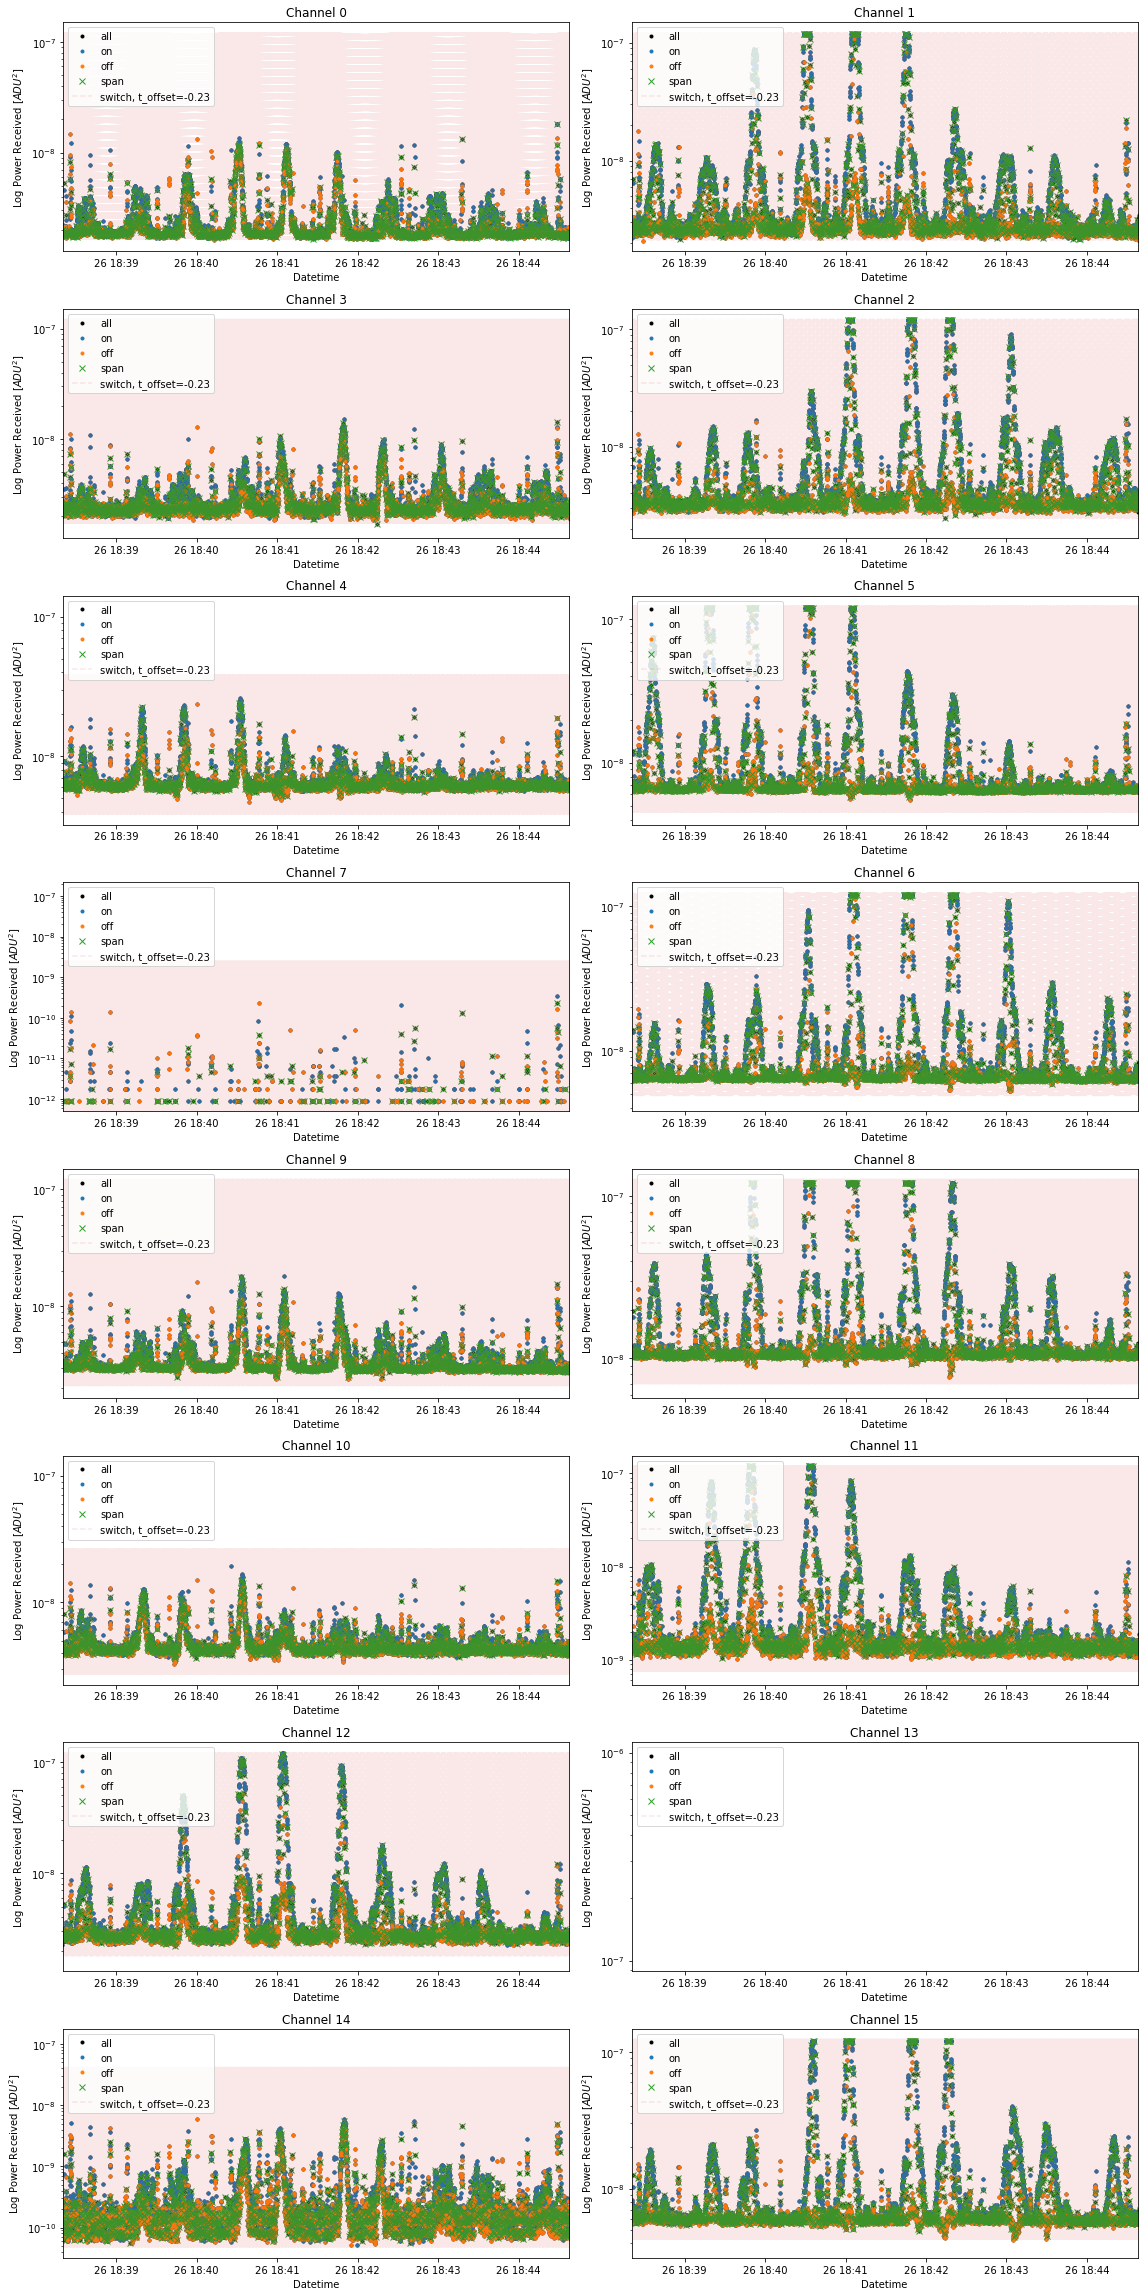

In [68]:
## OBJECTIVE 5A: concat Function: Extract_Source_Pulses

## Let's use the Extract_Source_Pulses function:
    # The Period and Dutycycle options are known beforehand, and given in microseconds.
    # The t_bounds option just determines the plot bounds, not the solving routine.
## Fortunately, these parameters are loaded from the config, so we don't have to wait for the solver to run.
    ## The returned t_delta_pulse parameter will be given in seconds.
    ## In the verification plot, we should see the following points plotted:
        # orange_o = inds_off  = times when the source is off
        # blue_o   = inds_on   = times when the source is on and broadcasting
        # green_x  = inds_span = times where the behavior changes during the integration period (omit always!)
    ## The print statements shows the list of indices that appear in more than one of on/off/span.
        ## If they are all empty lists [], then there is no overlap which is a good thing.
concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[tlb,tub])

In [77]:
## OBJECTIVE 5B: concat Function: Perform_Background_Subtraction

## Let's do background subtraction: creates computed background (V_bg) and background-subtracted (V_bgsub) arrays:
    # window_size=5 - this is 1/2 the width of the 'index window' across which the background is averaged.
    # This function only works if the source was pulsed and Extract_Source_Pulses was used!
concattest0825.Perform_Background_Subtraction(window_size=5)

Calculating background spectra from indices where the noise source is off.


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:323: RuntimeWarning: Mean of empty slice
  self.V_bg[k,:,:]=np.nanmean(self.V[t_window,:,:],axis=0)


  --> Background subtraction completed using window_size = 5


Synchronizing data from correlator and drone:
  --> Previous t_delta_dji not found
  --> Calculating via 2DGauss fitting routine:


/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


Applying a time correction of -0.08 seconds using Channel 1 fits.
  --> Variable synchronation successful, generating output plots:
  --> Saving output plot.


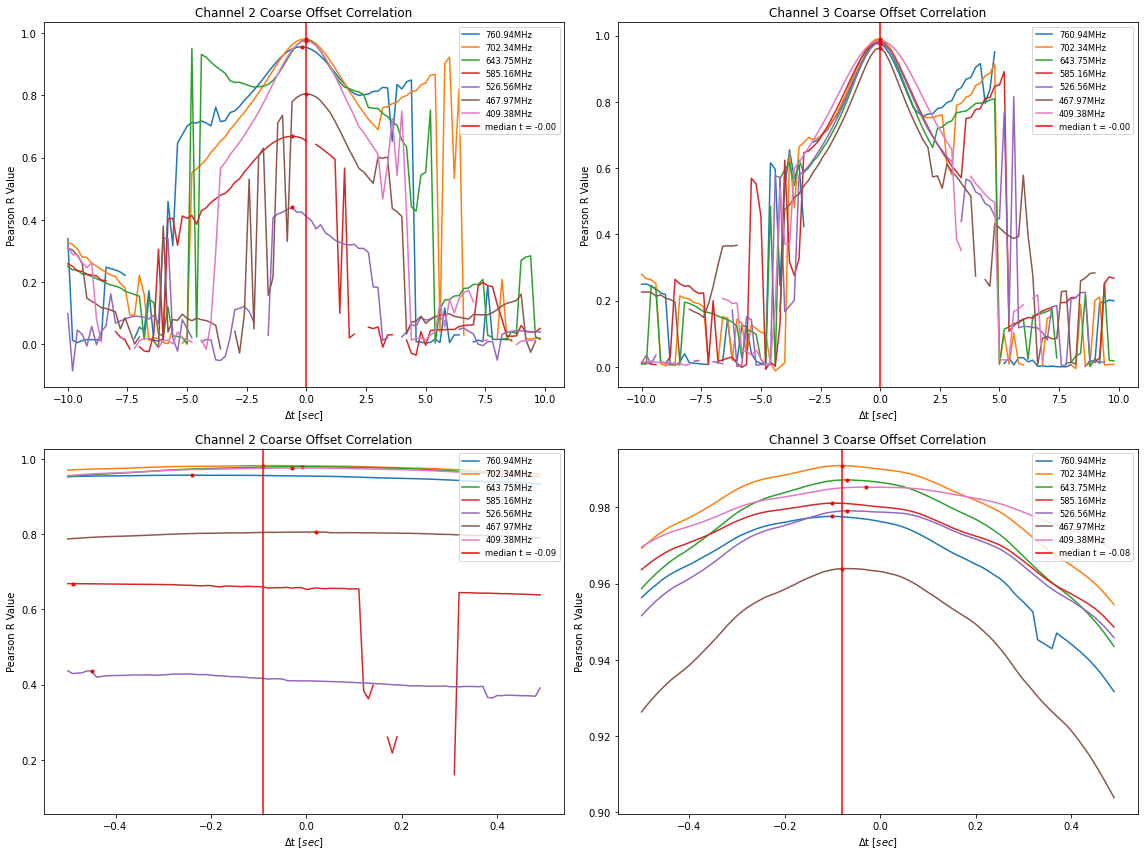

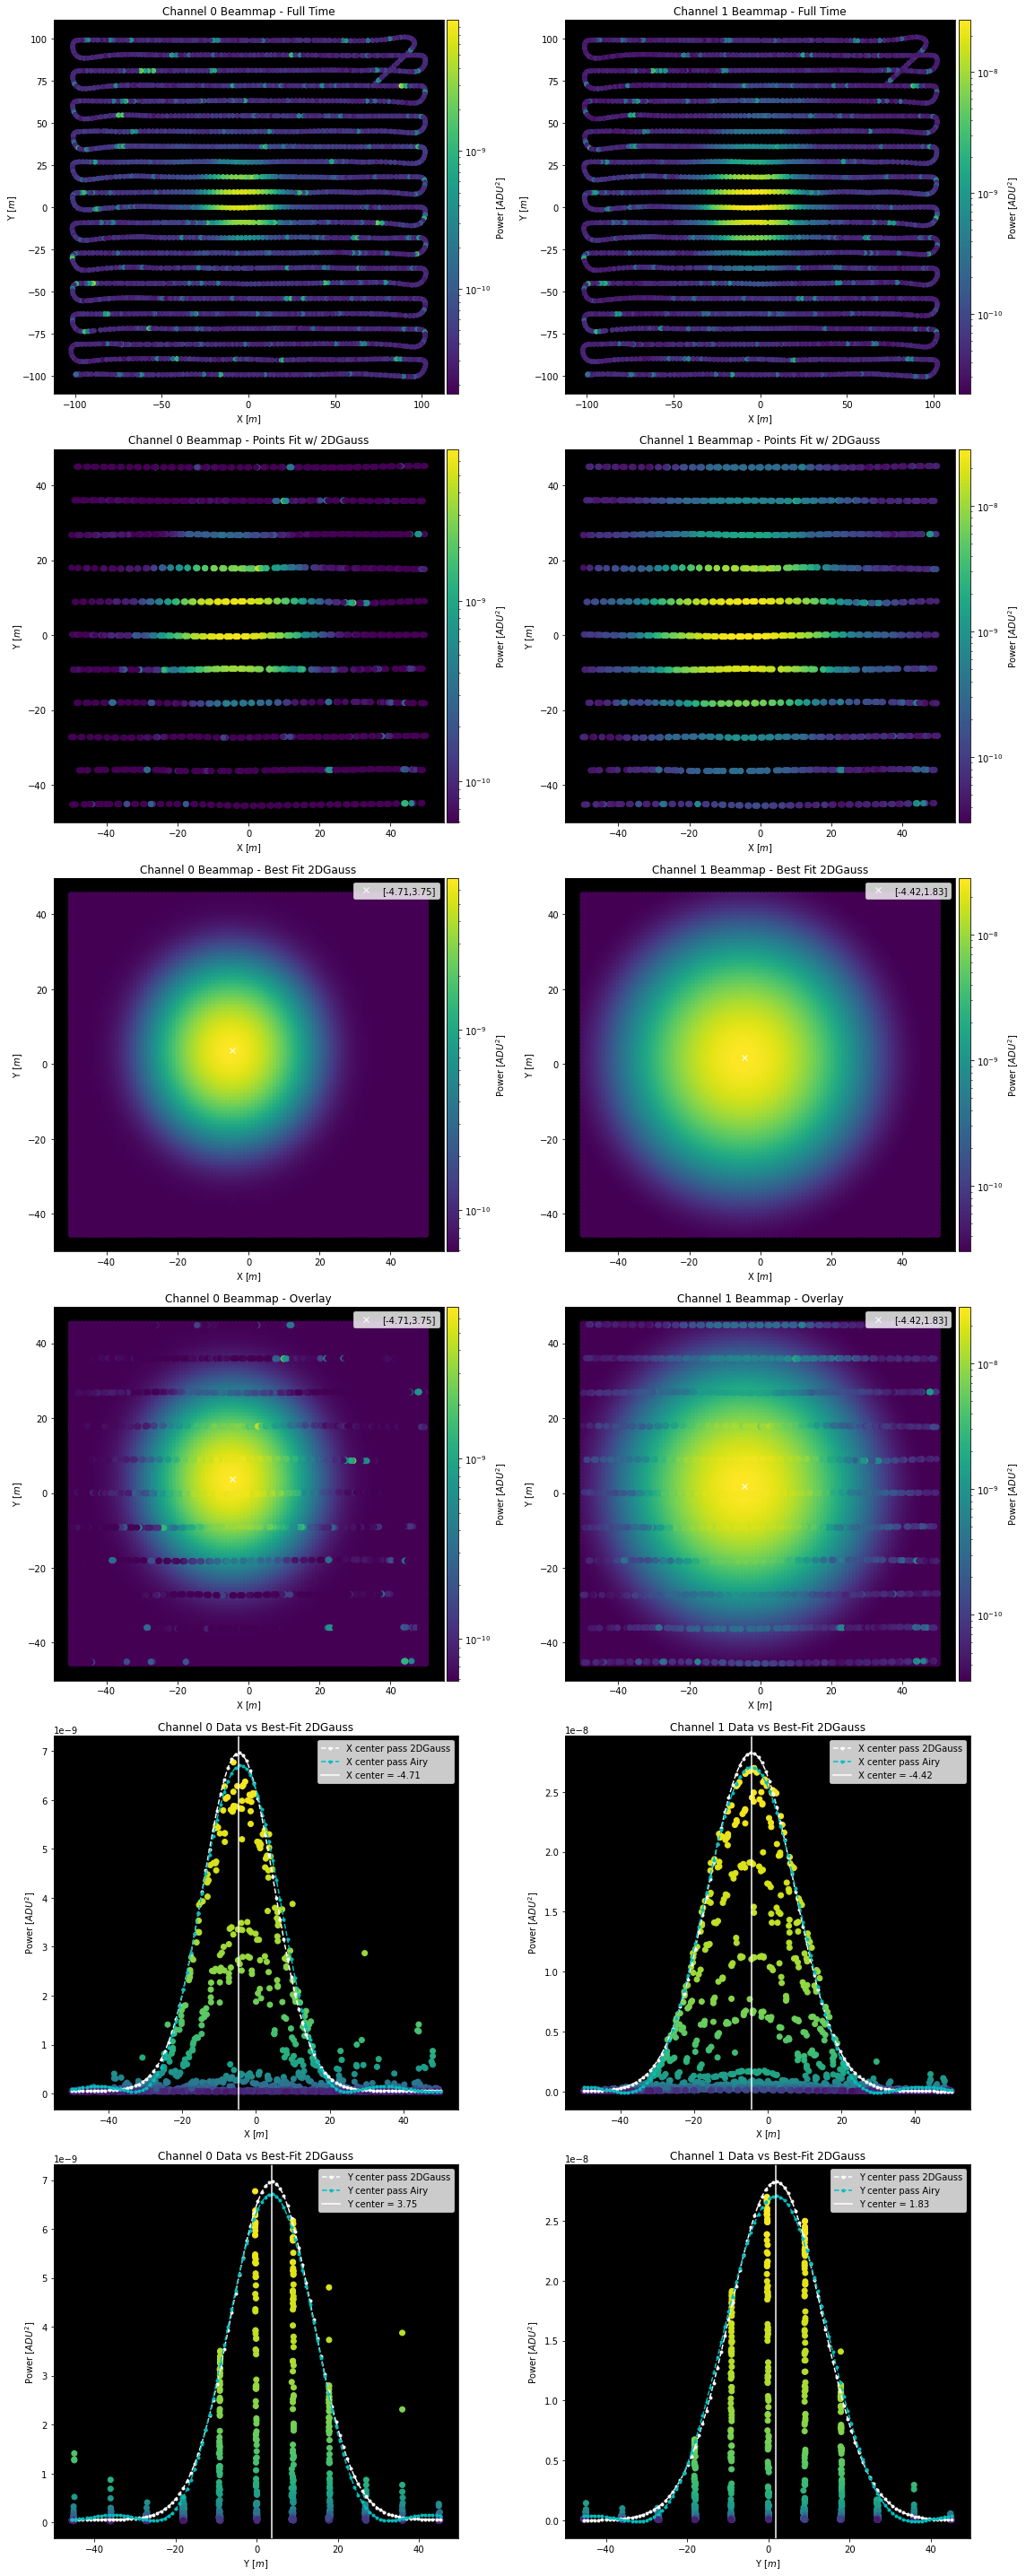

In [78]:
## OBJECTIVE 5C: concat Function: Synchronization_Function

## This function finds the absolute timing shift between the dji data from the drone and the correlator
    ## We will be loading t_delta_dji from the config file to save some time!
    ## This function only works if the source was pulsed and if V_bgsub was created using background subtraction.
    ## This function works by zooming into the gaussian main beam and removing saturated data points...
## To run, you must give the following:
    ## inputcorr  = the corr class used in the concat
    ## inputdrone = the drone class used in the concat
## The optional parameters and their default values are listed below:
    ## coarse_params=[-10.0,10.0,0.2]    = the min,max,step parameters for the coarse time offset array
    ## fine_params=[-0.5,0.5,0.01]       = the min,max,step parameters for the fine time offset array
    ## chans=np.arange(0,2)              = the channels to fit. 0,1 gives us each polarization
    ## freqs=np.arange(100,1024,150)     = the min,max,step parameters for the freq array axis
    ## FMB_coordbounds=[50.0,50.0,150.0] = the cartesian coords we restrict around the main beam
        # x within +/- 50m from dish center in Local Cartesian (LC)
        # y within +/- 50m from dish center in Local Cartesian (LC)
        # z > 150m from dish center in Local Cartesian (LC)
    ## FMB_ampbound=0.999                = amplitude percentile threshold for saturation... 
        # time indices where the amplitude exceeds 0.999*maximum value are excluded because they are saturated

concattest0825.Synchronization_Function(inputcorr=corrtest0825,inputdrone=dronetest0825,FMB_coordbounds=[50.0,50.0,150.0],FMB_ampbound=0.999)

## Since we are loading from the config, we get to skip an iterative loop and just take the solution and apply it.
    ## The verification plot shown is hidden when traceback==False is set in the concat initialization
    ## Look closely at the verification plots to see which channel appears to be the co-pol (channel 1)
    ## In the bottom 2 panels, compare the fit result (white gaussian) to the data points (in color)
        ## We are omitting the saturated points to find the REAL max value, instead of squashing our peak
        ## If we are satisfied with this fit, we should try to save the parameters we found...

In [82]:
## OBJECTIVE 5D: concat Function: Export_yaml

## When we have results we want to save, we should export our results to a config file for future use:
    ## The file will be written to the directory stated when the concat class was initialized.
    ## If a concat config yaml file already exists, a new version will be saved.
## Uncomment this if you want to export a config file... 
concattest0825.Export_yaml()

Preparing to export configuration file:
  --> Checking directory for config_FLY533_20210826T182904Z.yaml:
    --> FILE EXISTS
    --> preparing to write a new versioned configuration file...
    --> file saved successfully


In [83]:
## OBJECTIVE 5E: concat Function: Main_Beam_Fitting

## Now we can do some analysis, since we have synchronized useful data. We can begin by fitting the main beam:
    ## You can specify the directory where you want the fit params to be output:
    ## fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
    ## This one sometimes takes a while, feel free to get a coffee or something.
concattest0825.Main_Beam_Fitting(fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/')

Performing 2DGauss and Airy fits for [16]chans x [1024]freqs:


/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


  --> Saving output fit parameters as an .npz filetype:
  --> FLY533_20210826T182904Z_ver_20230311T143009_2dGauss_and_Airy_Params.npz


1


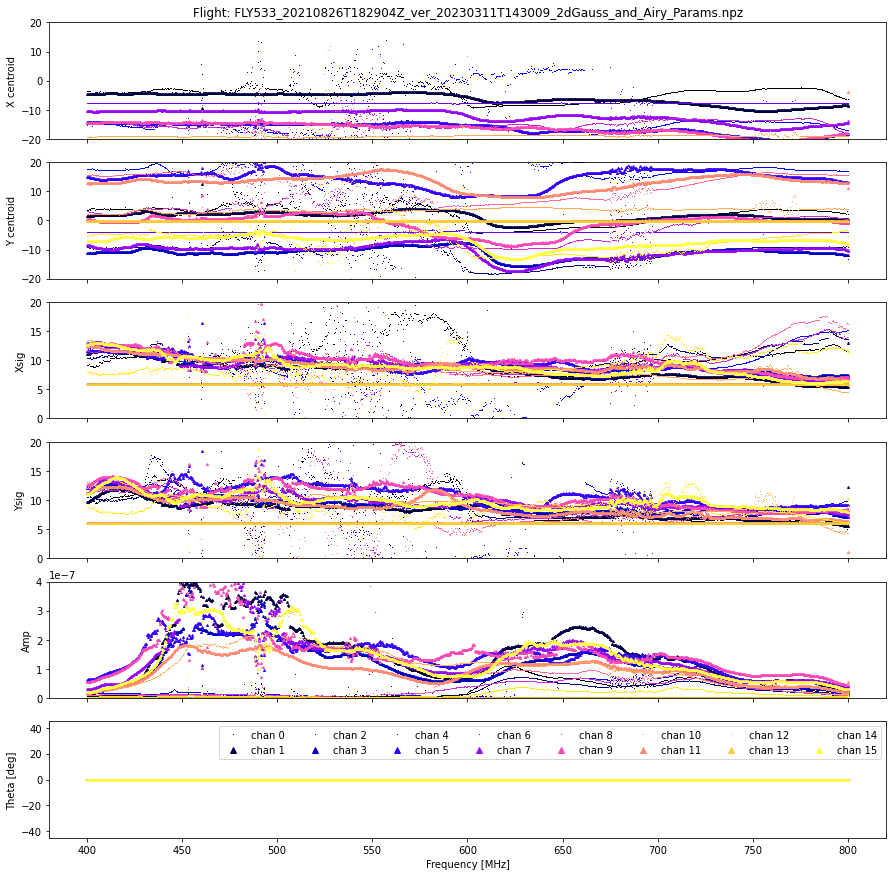

In [84]:
# checking all of the fits ###
filelist=['FLY533_20210826T182904Z_ver_20230311T143009_2dGauss_and_Airy_Params.npz']
pu.plot_MBG_fits(filelist,cmp='gnuplot2')

In [85]:
## let's try some operations to save it

# write a reduced class
[a for a in dir(concattest0825) if not a.startswith('__')] # prints out all attrs

['A_PR',
 'A_popt',
 'Config_Directory',
 'Data_Directory',
 'Drone_Directory',
 'Export_yaml',
 'Extract_Source_Pulses',
 'FLYTAG',
 'G_PR',
 'G_popt',
 'Gain_Directory',
 'Main_Beam_Fitting',
 'Output_Directory',
 'Output_Prefix',
 'Perform_Background_Subtraction',
 'Synchronization_Function',
 'V',
 'V_bg',
 'V_bgsub',
 'V_cross',
 'V_cross_bg',
 'V_cross_bgsub',
 'automap',
 'chmap',
 'copolchan',
 'crossmap',
 'dish_coords',
 'dish_keystrings',
 'dish_pointings',
 'dish_polarizations',
 'drone_llh_interp',
 'drone_rpt_interp',
 'drone_rpt_r_per_dish_interp',
 'drone_rpt_t_per_dish_interp',
 'drone_xyz_LC_interp',
 'drone_yaw_interp',
 'filenames',
 'freq',
 'gainfile',
 'inds_off',
 'inds_on',
 'inds_span',
 'load_yaml',
 'n_channels',
 'n_dishes',
 'name',
 'origin',
 'prime_origin',
 'pulse_dutycycle',
 'pulse_period',
 'save_traceback',
 'switch_signal',
 'switch_signal_interp',
 'switch_time',
 't',
 't_arr_datetime',
 't_delta_dji',
 't_delta_pulse',
 't_index',
 'traceback',

In [93]:
# pickle the concat attributes::::

# would be nice to loop over attr names instead of having to write them out by hand...............
tmpcorrdir=concattest0825.Data_Directory.split("_yale")[0].split("TONE_ACQ/")[1]
tmpdronedir=concattest0825.FLYTAG.split('.')[0]
suff=datetime.datetime.now().strftime("%Y%m%dT%H%M%S")
Output_Prefix='{}_{}_ver_{}'.format(tmpdronedir,tmpcorrdir,suff)
tmppath=Output_Prefix+'_concat.pkl'
print(tmppath)
# need to choose a directory and add it to tmppath

class Smallify:
    def __init__(self,concatclass):
        self.drone_xyz_LC_interp = concatclass.drone_xyz_LC_interp
        self.chmap = concatclass.chmap
        self.crossmap = concatclass.crossmap
        self.Data_Directory = concatclass.Data_Directory
        self.drone_yaw_interp = concatclass.drone_yaw_interp
        self.freq = concatclass.freq
        self.t_arr_datetime = concatclass.t_arr_datetime
        #self.V = concatclass.V
        self.inds_off = concatclass.inds_off
        self.inds_on = concatclass.inds_on
        self.inds_span = concatclass.inds_span
        self.pulse_dutycycle = concatclass.pulse_dutycycle
        self.pulse_period = concatclass.pulse_period
        self.switch_signal = concatclass.switch_signal
        self.switch_signal_interp = concatclass.switch_signal_interp
        self.V_bg = concatclass.V_bg
        self.V_cross = concatclass.V_cross
        self.V_cross_bg = concatclass.V_cross_bg
        self.V_cross_bgsub = concatclass.V_cross_bgsub
        self.t = concatclass.t
        self.t_delta_dji = concatclass.t_delta_dji
        self.t_delta_pulse = concatclass.t_delta_pulse
        self.G_popt = concatclass.G_popt
        
thingy = Smallify(concattest0825)
with open('test_er.pkl', 'wb') as outp:
    pickle.dump(thingy, outp, pickle.HIGHEST_PROTOCOL)
    
with open('test_er.pkl', 'rb') as inp:
    ptest = pickle.load(inp)



FLY533_20210826T182904Z_ver_20230311T154637_concat.pkl


MemoryError: 